# Assignment #4


# 1. Basics of Geostatistics (25 pts)

Each observation of an environmental variable in space $z(\mathbf{x})$ can be interpreted as a single realization of a random variable $Z(\mathbf{x})$. Where $\mathbf{x}$ denotes the position in space of the observation. In a given finite region there can be an infinite number of locations $\mathbf{x}$ and thus an infinite number of random variables $Z(\mathbf{x})$. The set of all these random variables $Z(\mathbf{x})$ constitutes a random process. For the remainder of this problem assume $Z_i = Z(\mathbf{x})$ and $z_i = z(\mathbf{x})$.

A. Explain the difference between $z_i$ and $Z_i$.

B. Based on the lectures, define $Z^*$ and $Z_0$. Explain the difference between the two. 

C. Describe the meaning of $\text{Cov}(Z_i,Z_j)$, $\text{Cov}(Z_i,Z_0)$, $\text{Var}(Z_0)$.

D. The Simple Kriging system is given by $\Sigma \mathbf{w} = \mathbf{c}$. Explain each term in that equation.

E. Once $\mathbf{w}$ is computed, how can it be used to estimate $z^*$? 

F. What is second-order stationarity?

G. Assuming second-order stationarity, if we are interested in the covariance between $Z_i$ and $Z_j$, why do we concern ourselves with the semivariogram?

H. Starting from the definition of covariance, derive the relationship between covariance and semivariogram. 

### Part A
$Z_i$ is a random variable observed at position x, and $z_i$ is a realization of $Z_i$ observed at position x.

### Part B
$$Z^* = \sum_{i=1}^N w_i Z_i$$
$Z_0$ is the true unknown value of random variable Z, while $Z^*$ is an estimate of the random variable.

### Part C
$\text{Cov}(Z_i,Z_j)$ is the covariance between the 2 observations of random variable Z. $\text{Cov}(Z_i,Z_0)$ is the covariance between one observation and the true unknown value of the random variable. $\text{Var}(Z_0)$ is the variance of the random variable itself.

### Part D
$\Sigma$ is the covariance matrix of all observations. $\mathbf{w}$ is the vector of weights. $\mathbf{c}$ is the vector of covariances between the observations and the true value.

### Part E
We can estimate $z^*$ by getting the linear combination of the dot products of $\mathbf{w}$ and $z_i$. i.e. $z^* = \sum_{i=1}^N w_i z_i$.

### Part F
Second-order stationarity means the mean and variance are constant and the covariance between two points only relies on distance.

### Part G
Because when at second-order stationarity, there might be negative values produced by covariance, and $Z_i$ and $Z_j$ will be only related by $\gamma = \text{Var}[Z] - \text{Cov}(Z_i, Z_j)$.

### Part H
Covariance is $$\text{Cov}(Z_i,Z_j) = E[Z_iZ_j] - E[Z_i]E[Z_j]$$
Semivariogram is $$\gamma = E[(Z_i - Z_j)^2] = E[Z_i^2] - 2E[Z_iZ_j] + E[Z_j^2]$$
Solve for $E[Z_iZ_j]$: $$E[Z_iZ_j] = E[Z_i^2]/2 + E[Z_j^2]/2 - \gamma$$
Plug that into the definition of covariance: $$\text{Cov}(Z_i,Z_j) = \frac{E[Z_i^2]}{2} + \frac{E[Z_j^2]}{2} - \gamma - E[Z_i]E[Z_j]$$
Given that we assume second-order stationarity, then: $$E[Z] = E[Z_i] = E[Z_j]$$  
$$\text{Cov}(Z_i,Z_j) = \frac{E[Z_i^2] - E[Z_i]^2}{2} + \frac{E[Z_j^2] - E[Z_j]^2}{2} - \gamma$$  
$$\text{Cov}(Z_i,Z_j) = \frac{\text{Var}[Z_i]}{2} + \frac{\text{Var}[Z_j]}{2} - \gamma$$
Again because we are assuming second-order stationary: $$\text{Var}[Z] = \text{Var}[Z_i] = \text{Var}[Z_j]$$
We can get: $$\text{Cov}(Z_i,Z_j) = \text{Var}[Z] - \gamma$$

# 2. Computing the semivariogram (25 pts)

Using data from the samples group in `/data/HW/HW4.nc`:

A. Assemble the isotropic cloud semivariogram. Plot the results. Only consider distances up to 25000 m. 

B. Having computed the cloud semivariogram, assemble the sample semivariogram using a bin size of 500 m. Plot the results. Only consider distances up to 25000 m.

C. Fit an exponential, spherical, and bounded linear semivariogram to the sample semivariogram. Compute the $R^2$ of each fit then plot the results. Remember to set bounds for the curve fitting, if not it won't converge. Based on your results, which model semivariogram would you use for the region?

## Part A

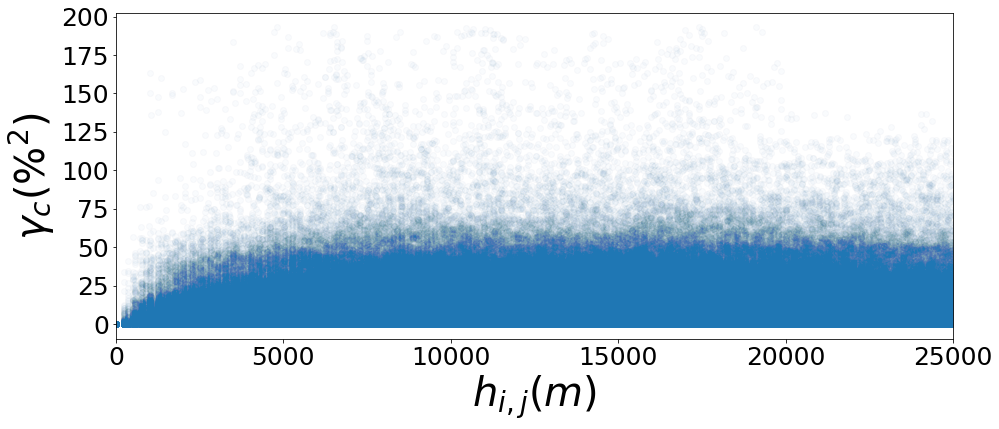

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

fp = xr.open_rasterio('/data/HW/HW4/HW4.nc')
data = np.array(fp[0, :, :])
x = np.array(fp['x'][:])
y = np.array(fp['y'][:])

#Let's randomly sample n different points
nsamples = int(0.1 * (x.size * y.size))
#Randomly sample n points on the domain
np.random.seed(1)
(xs,ys) = np.meshgrid(np.arange(x.size),np.arange(y.size))
ipoints = np.random.choice(np.arange(x.size * y.size), nsamples, replace=False)
ix = xs.ravel()[ipoints]
iy = ys.ravel()[ipoints]
#Extract the points
x_points = 250 * x[ix] + 250.0 / 2
y_points = 250 * y[iy] + 250.0 / 2
#Extract the data
data_points = []
for i in range(iy.size):
    data_points.append(data[iy[i],ix[i]])
data_points = np.array(data_points)

#Compute euclidean distances from observatins to observations
h = ((x_points[:, np.newaxis] - x_points.T)**2 + (y_points[:, np.newaxis] - y_points.T)**2)**0.5

# Compute variogram cloud by comparing all points
gamma_c = (data_points[:, np.newaxis].T - data_points[:, np.newaxis])**2 / 2

#Reshape to 1d arrays
h = h.reshape(h.size)
gamma_c = gamma_c.reshape(gamma_c.size)

plt.figure(figsize=(15, 6))

#Make the scatter plot
plt.scatter(h, gamma_c, alpha=0.01)

#Let's only consider points that are up to 25000 meters away from each other
plt.xlim([0, 25000])

#Pretty up the plot
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h_{i,j} (m)$',fontsize=40)
plt.ylabel(r'$\gamma_c(\%^2)$',fontsize=40)
plt.show()

## Part B

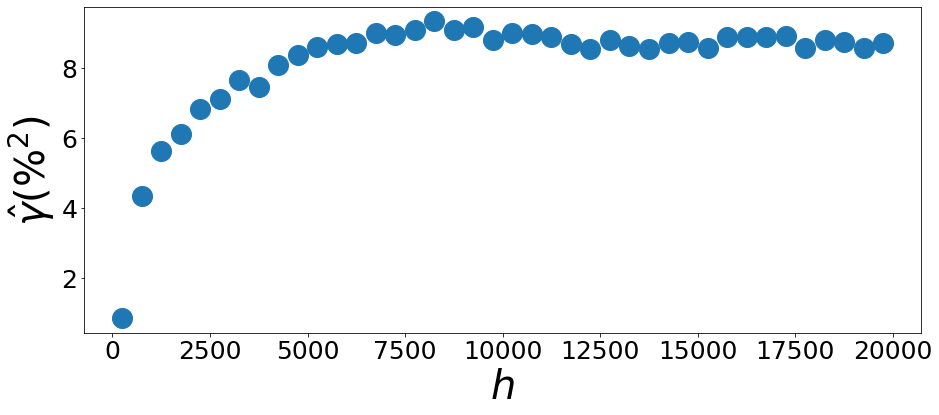

In [14]:
#Define delta
delta = 500 #m

#Define bin edges
bin_edges = np.linspace(0,20000,20000 / delta + 1)

#Compute the center of each bin
hd = (bin_edges[1:] + bin_edges[0:-1])/2

#Compute sample semivariogram
gamma_s = []
for i in range(hd.size):
    if i == 0:m = (h >= bin_edges[i]) & (h < bin_edges[i + 1])
    else:m = (h > bin_edges[i]) & (h <= bin_edges[i + 1])
    tmp = np.mean(gamma_c[m])
    gamma_s.append(tmp)
gamma_s = np.array(gamma_s)

plt.figure(figsize=(15,6))
plt.plot(hd,gamma_s,'o',markersize=20)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\hat{\gamma}(\%^2)$',fontsize=40)
plt.show()

## Part C

In [26]:
import scipy.optimize
from sklearn.metrics import r2_score

def exponential_semivariogram(h, c, tau):
    return c * (1 - np.exp(-h / tau))

def spherical_semivariogram(h, c, a):
    res = []
    for h_i in h:
        if h_i <= a:
            res.append(c * (1.5 * h_i / a - 0.5 * h_i**3 / (a**3)))
        else:
            res.append(c)
    return np.array(res)

def bounded_linear_semivariogram(h, c, a):
    res = []
    for h_i in h:
        if h_i <= a:
            res.append(c * h_i / a)
        else:
            res.append(c)
    return np.array(res)

R^2: 0.967159


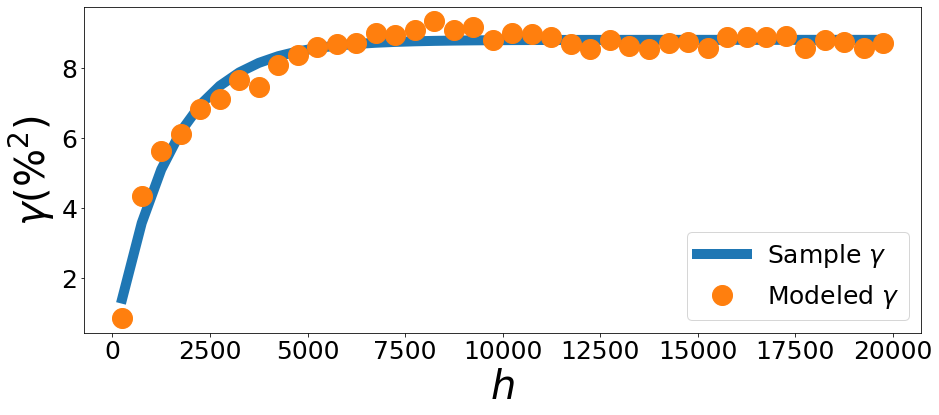

In [23]:
# Exponential
popt, pcov = scipy.optimize.curve_fit(exponential_semivariogram,hd,gamma_s,bounds=([0,1000],[100,25000]))
print(r'R^2: %f' % r2_score(gamma_s, exponential_semivariogram(hd,*popt)))

plt.figure(figsize=(15,6))
plt.plot(hd,exponential_semivariogram(hd,*popt),lw=10)
plt.plot(hd,gamma_s,'o',markersize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\gamma(\%^2)$',fontsize=40)
plt.legend([r'Sample $\gamma$',r'Modeled $\gamma$'],fontsize=25)
plt.show()

R^2: 0.901294


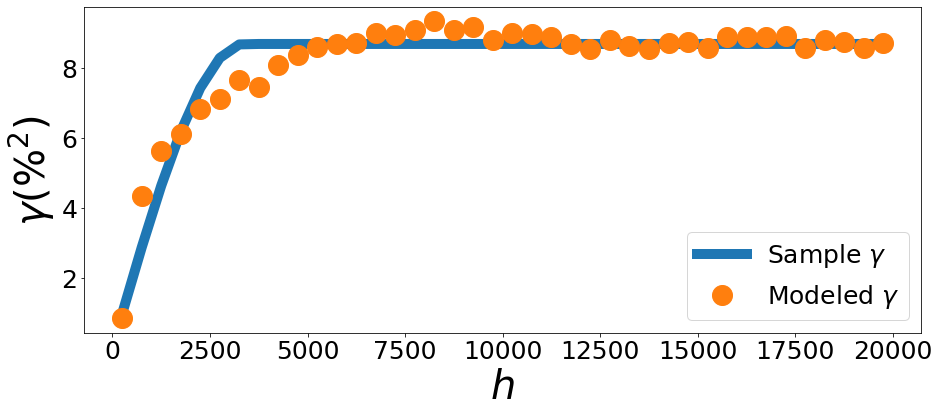

In [28]:
# Spherical
popt, pcov = scipy.optimize.curve_fit(spherical_semivariogram,hd,gamma_s,bounds=([0,1000],[100,25000]))
print(r'R^2: %f' % r2_score(gamma_s, spherical_semivariogram(hd,*popt)))

plt.figure(figsize=(15,6))
plt.plot(hd,spherical_semivariogram(hd,*popt),lw=10)
plt.plot(hd,gamma_s,'o',markersize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\gamma(\%^2)$',fontsize=40)
plt.legend([r'Sample $\gamma$',r'Modeled $\gamma$'],fontsize=25)
plt.show()

R^2: 0.853063


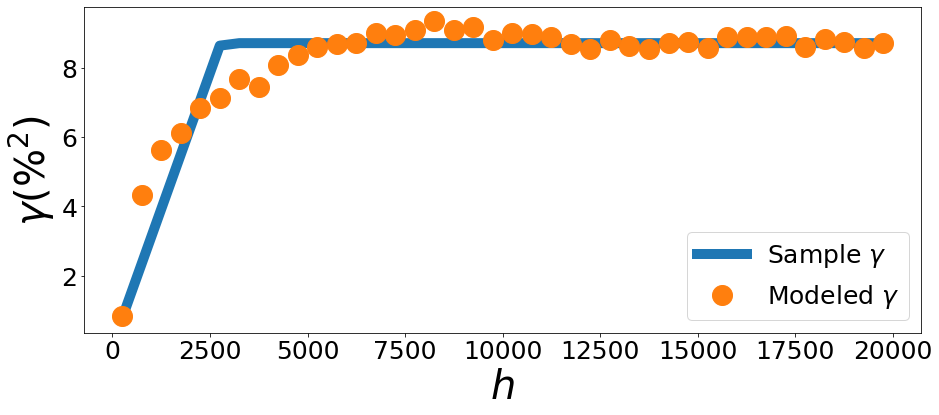

In [29]:
# Bounded Linear
popt, pcov = scipy.optimize.curve_fit(bounded_linear_semivariogram,hd,gamma_s,bounds=([0,1000],[100,25000]))
print(r'R^2: %f' % r2_score(gamma_s, bounded_linear_semivariogram(hd,*popt)))

plt.figure(figsize=(15,6))
plt.plot(hd,bounded_linear_semivariogram(hd,*popt),lw=10)
plt.plot(hd,gamma_s,'o',markersize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\gamma(\%^2)$',fontsize=40)
plt.legend([r'Sample $\gamma$',r'Modeled $\gamma$'],fontsize=25)
plt.show()

Based on the result, I would choose expoential semivariogram.

# 3. Ordinary Kriging (25 pts)

Using the data in the samples group in '/data/HW/HW4/HW4.nc', and assumming an exponential semivariogram with a sill ($c$) of 10.0 $\%^2$, a nugget of 0, and a range ($a$) of 1500 m, do the following:

A. Use ordinary kriging to try to reproduce the original map of sand (as found in the original_data group in `/data/HW/HW4/HW4.nc`).

B. Plot the reproduced map and the original map. Compare the two via the $R^2$.

C. Compute the estimated mean squared error at each grid cell (kriging variance) and plot the map. Discuss the results. 

D. One of the largest limitations of Kriging is that the observation covariance matrix can become too large. Another more practical approach is to only use the closest $n$ points to each point to which we interpolate. Setting $n = 10$, perform this "localized" ordinary kriging and compare the results to those from part B. 

E. Repeat part D. However, this time set $n=1$. What other deterministic spatial interpolation method does this now mimic?

## Part A

In [79]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn
from sklearn.metrics import r2_score

fp=xr.open_rasterio('/data/HW/HW4/HW4.nc')
data = np.array(fp[0,:,:])
x = np.array(fp['x'][:])
y = np.array(fp['y'][:])

#Let's randomly sample n different points
nsamples = int(0.1*(x.size*y.size))
#Randomly sample n points on the domain
np.random.seed(1)
(xs,ys) = np.meshgrid(np.arange(x.size),np.arange(y.size))
ipoints = np.random.choice(np.arange(x.size*y.size),nsamples,replace=False)
ix = xs.ravel()[ipoints]
iy = ys.ravel()[ipoints]
#Extract the points
y_points = y[iy]
x_points = x[ix]
#Extract the data
data_points = []
for i in range(iy.size):
    data_points.append(data[iy[i],ix[i]])
data_points = np.array(data_points)

#Define variance
var = 10
#Define tau
tau = 1500
#Define grid positioning
x_grid = x[xs]
y_grid = y[ys]
#Let's reshape our data to a 1d array
xg1d = x_grid.reshape(x_grid.size)
yg1d = y_grid.reshape(y_grid.size)
#Compute euclidean distances from observations to points on grid
dist = ((xg1d[:,np.newaxis] - x_points.T)**2 + (yg1d[:,np.newaxis] - y_points.T)**2)**0.5
#Compute covariance matrix C
C = var*np.exp(-dist/tau).T
#Compute euclidean distances from observatins to observations
dist = ((x_points[:,np.newaxis] - x_points.T)**2 + (y_points[:,np.newaxis] - y_points.T)**2)**0.5
#Compute covariance matrix Sigma
Sigma = var*np.exp(-dist/tau).T
#Append the extra information for the langrange multipliers
#Sigma_prime
Sigma_prime = np.zeros((Sigma.shape[0]+1,Sigma.shape[1]+1))
Sigma_prime[0:-1,0:-1] = Sigma[:]
Sigma_prime[-1,0:-1] = 1
Sigma_prime[0:-1,-1] = 1
#C_prime
C_prime = np.zeros((C.shape[0]+1,C.shape[1]))
C_prime[0:-1,:] = C[:,:]
C_prime[-1,:] = 1

# Solve for the weights
W = np.linalg.solve(Sigma_prime,C_prime)

#Compute zstar
zt = data_points[:]
zstar = np.sum(W[0:-1,:]*zt[:,np.newaxis],axis=0)
#Compute mse 
mse = var - np.sum(W[0:-1,:]*C_prime[0:-1,:],axis=0) - W[-1,:]

## Part B

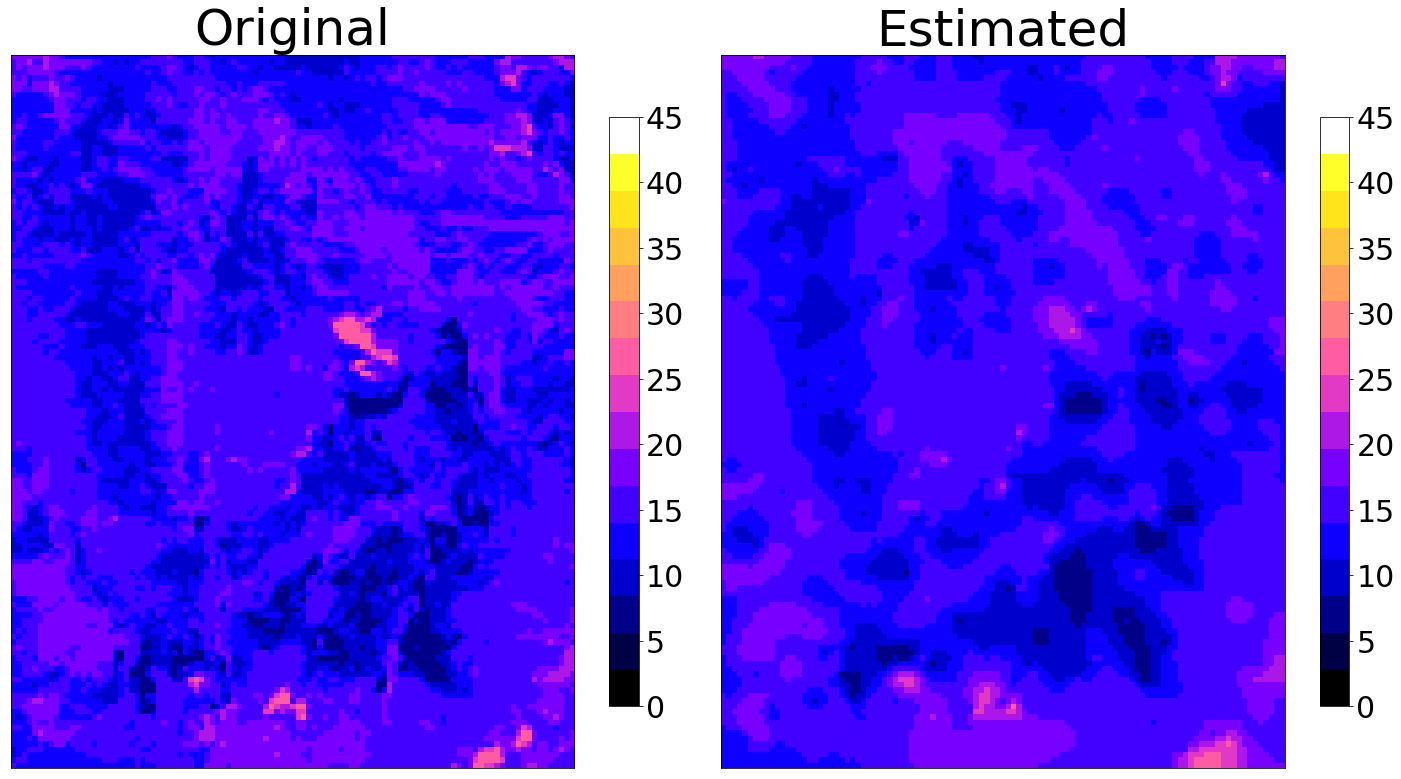

In [80]:
import matplotlib.cm as cm
vmin = 0
vmax = 45
#Plot the original and kriged data side by side
ypred = zstar.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Estimated',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

In [81]:
print(r'R2: %f' % sklearn.metrics.r2_score(data.reshape(data.size),ypred.reshape(ypred.size)))

R2: 0.602772


## Part C

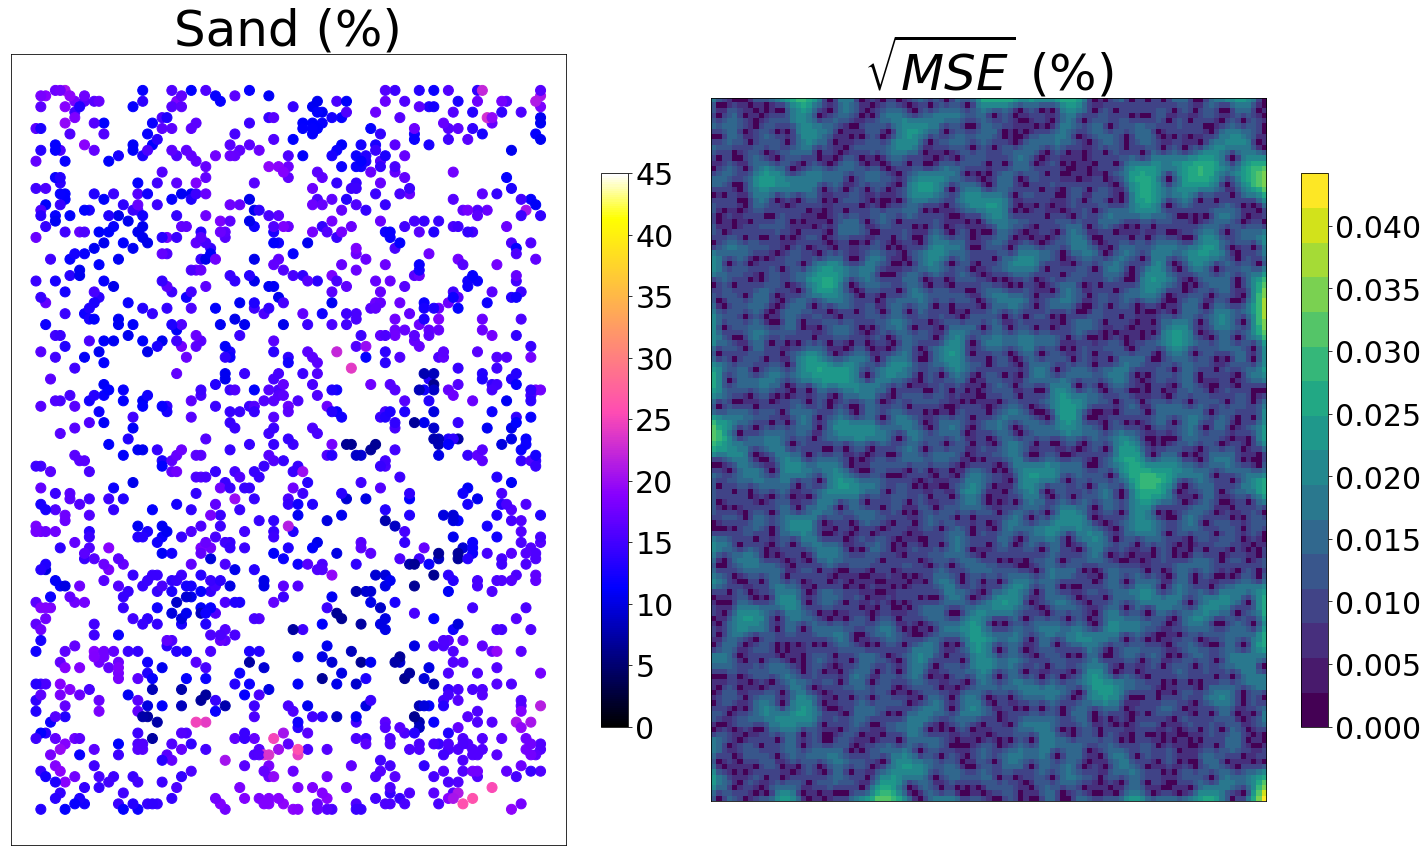

In [82]:
#Plot the original and kriged data side by side
mse_grid = mse.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(mse_grid,cmap=cm.get_cmap('viridis',16))
plt.xticks([])
plt.yticks([])
plt.title(r'$\sqrt{MSE}$ (%)',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.scatter(ix,np.max(iy)-iy,c=data_points,s=100,vmin=vmin,vmax=vmax,cmap='gnuplot2')
plt.xticks([])
plt.yticks([])
plt.title('Sand (%)',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

When there is a data point, MSE value becomes lower. When there's no observing points, MSE value become larger.

## Part D

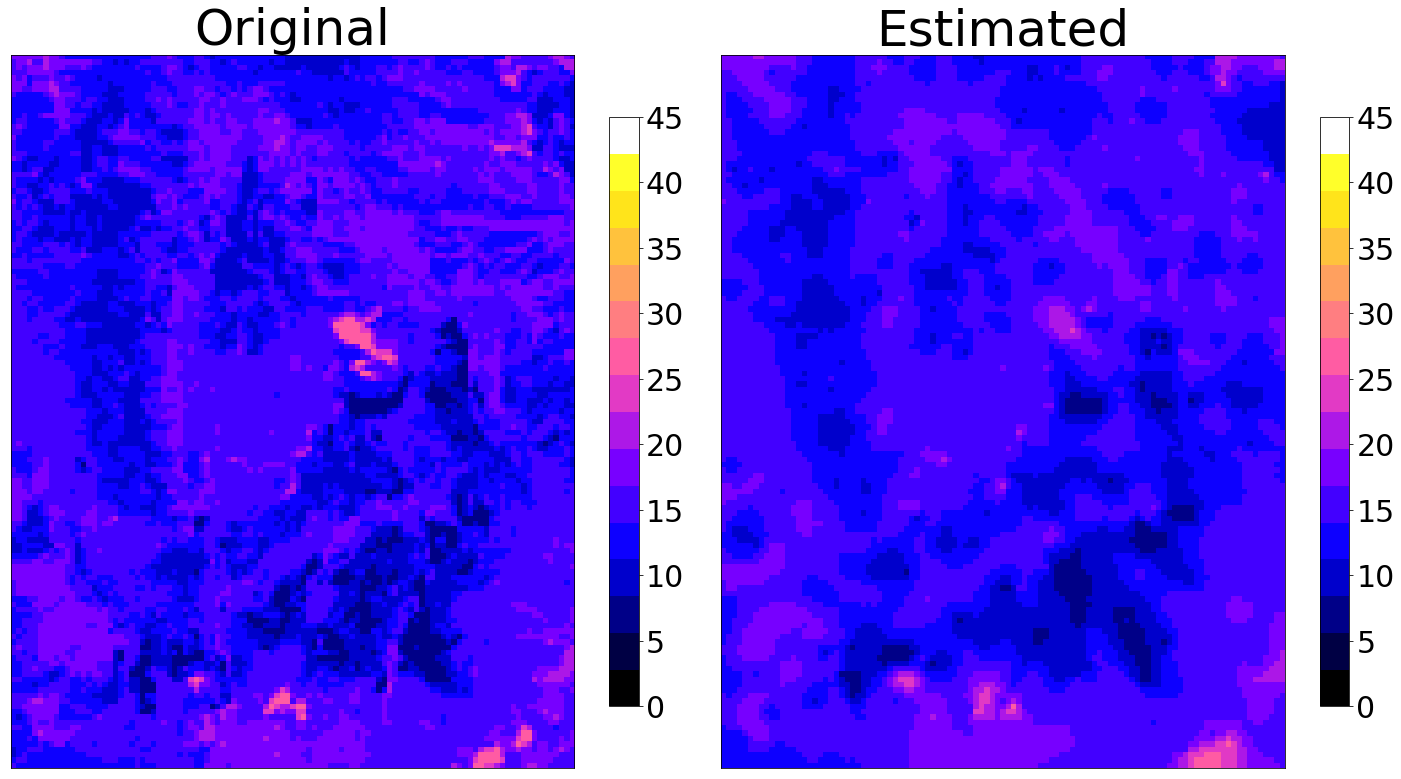

In [42]:
n = 10

#Compute euclidean distances from observations to points on grid
dist = ((xg1d[:,np.newaxis] - x_points.T)**2 + (yg1d[:,np.newaxis] - y_points.T)**2)**0.5

# the nearest n neighbors
obs_nn_dist = np.sort(dist, axis=1)[:,:n]
obs_nn_idx = np.argsort(dist, axis=1)[:,:n]

zstar_list = []

for i in range(len(obs_nn_dist)):
    # distance between n nearest obs and the pixel
    dist_i = obs_nn_dist[i][:,np.newaxis]
    #Compute covariance matrix C
    C = var*np.exp(-dist_i/tau)
    #Compute euclidean distances from observatins to observations
    x_obs, y_obs = x_points[obs_nn_idx[i]], y_points[obs_nn_idx[i]]
    dist_i = ((x_obs[:,np.newaxis] - x_obs.T)**2 + (y_obs[:,np.newaxis] - y_obs.T)**2)**0.5
    #Compute covariance matrix Sigma
    Sigma = var*np.exp(-dist_i/tau).T
    #Append the extra information for the langrange multipliers
    #Sigma_prime
    Sigma_prime = np.zeros((Sigma.shape[0]+1,Sigma.shape[1]+1))
    Sigma_prime[0:-1,0:-1] = Sigma[:]
    Sigma_prime[-1,0:-1] = 1
    Sigma_prime[0:-1,-1] = 1
    #C_prime
    C_prime = np.zeros((C.shape[0]+1,C.shape[1]))
    C_prime[0:-1,:] = C[:,:]
    C_prime[-1,:] = 1

    # Solve for the weights
    W = np.linalg.solve(Sigma_prime,C_prime)

    #Compute zstar
    zt = data_points[obs_nn_idx[i]]
    zstar = np.sum(W[0:-1,:]*zt[:,np.newaxis],axis=0)
    zstar_list.append(zstar)

zstar = np.array(zstar_list)

vmin = 0
vmax = 45
#Plot the original and kriged data side by side
ypred = zstar.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Estimated',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

In [44]:
print(r'R2: %f' % sklearn.metrics.r2_score(data.reshape(data.size),ypred.reshape(ypred.size)))
print("The R2 score is very similar to Part B.")

R2: 0.602709
The R2 score is very similar to Part B.


## Part E

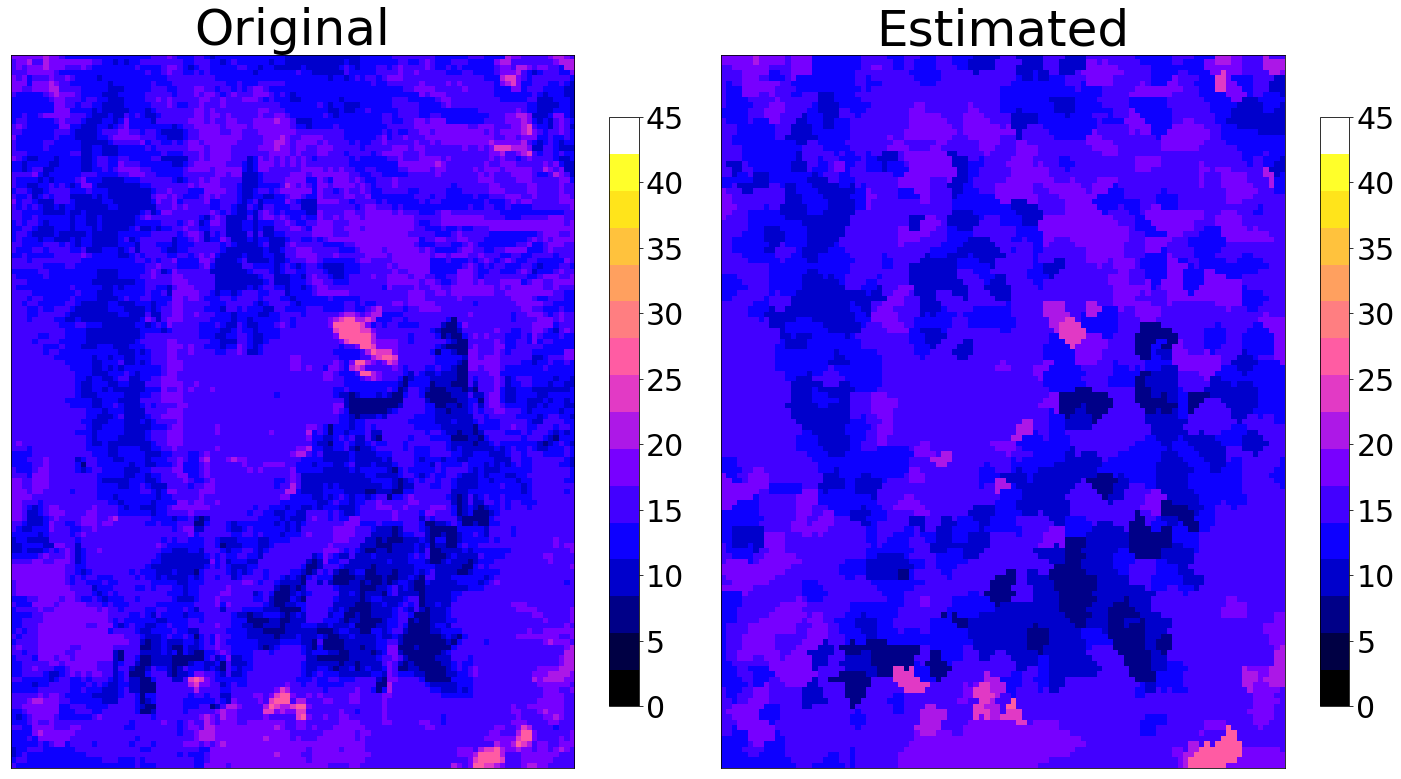

In [45]:
n = 1

#Compute euclidean distances from observations to points on grid
dist = ((xg1d[:,np.newaxis] - x_points.T)**2 + (yg1d[:,np.newaxis] - y_points.T)**2)**0.5

# the nearest n neighbors
obs_nn_dist = np.sort(dist, axis=1)[:,:n]
obs_nn_idx = np.argsort(dist, axis=1)[:,:n]

zstar_list = []

for i in range(len(obs_nn_dist)):
    # distance between n nearest obs and the pixel
    dist_i = obs_nn_dist[i][:,np.newaxis]
    #Compute covariance matrix C
    C = var*np.exp(-dist_i/tau)
    #Compute euclidean distances from observatins to observations
    x_obs, y_obs = x_points[obs_nn_idx[i]], y_points[obs_nn_idx[i]]
    dist_i = ((x_obs[:,np.newaxis] - x_obs.T)**2 + (y_obs[:,np.newaxis] - y_obs.T)**2)**0.5
    #Compute covariance matrix Sigma
    Sigma = var*np.exp(-dist_i/tau).T
    #Append the extra information for the langrange multipliers
    #Sigma_prime
    Sigma_prime = np.zeros((Sigma.shape[0]+1,Sigma.shape[1]+1))
    Sigma_prime[0:-1,0:-1] = Sigma[:]
    Sigma_prime[-1,0:-1] = 1
    Sigma_prime[0:-1,-1] = 1
    #C_prime
    C_prime = np.zeros((C.shape[0]+1,C.shape[1]))
    C_prime[0:-1,:] = C[:,:]
    C_prime[-1,:] = 1

    # Solve for the weights
    W = np.linalg.solve(Sigma_prime,C_prime)

    #Compute zstar
    zt = data_points[obs_nn_idx[i]]
    zstar = np.sum(W[0:-1,:]*zt[:,np.newaxis],axis=0)
    zstar_list.append(zstar)

zstar = np.array(zstar_list)

vmin = 0
vmax = 45
#Plot the original and kriged data side by side
ypred = zstar.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Estimated',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

In [47]:
print(r'R2: %f' % sklearn.metrics.r2_score(data.reshape(data.size),ypred.reshape(ypred.size)))
print("Now it mimics the Nearest Neighbors method.")

R2: 0.405897
Now it mimics the Nearest Neighbors method.


# 4. Calculate upslope drainage area (25 pts)

Using the elevation data found in `/data/HW/HW4/mtdiablo_dem_sf.tif`, show that the upslope drainage area flowing out of the grid cell point i = 582 and j = 779 is 12,856,300 $m^2$. You will need to write up your own recursive algorithm to estimate upslope drainage area for this problem. You will want to use the d8 flow direction approach. In other words, assume that if a ball is dropped on a given grid cell it will follow the path of steepest descent (i.e., the highest slope) to one (and only one) adjacent cell. Note that the pixel size is 10 meters by 10 meters. Furthermore, you may assume that this data has already been sink-filled.

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import rasterio
    
def find_neighbors(grid, x, y):
    neighbor_iterator = np.array([1, -1, 1, 0, 1, 1, 0, -1, 0, 1, -1, -1, -1, 0, -1, 1])
    neighbor_iterator.shape = (8, 2)
    neighbors=[]
    for i in range(8):
        xx = x + neighbor_iterator[i][0]
        yy = y + neighbor_iterator[i][1]
        if (xx > -1 and xx < grid.shape[0] and yy > -1 and yy < grid.shape[1]):
            neighbors.append([xx, yy])
    return neighbors

def find_lowest_neighbor(grid, x, y):
    if (x <= -1 or x >= grid.shape[0] or y <= -1 or y >= grid.shape[1]):
        return -10, -10
    neighbors = find_neighbors(grid, x, y)
    dem_diffs = []
    for neighbor in neighbors:
        dem_diffs.append(grid[x][y] - grid[neighbor[0], neighbor[1]])
    dem_diffs = np.array(dem_diffs)
    if np.max(dem_diffs) <= 0:
        return -10, -10
    steepest_index = np.argmax(dem_diffs)
    new_coordinate = np.array(neighbors[steepest_index])
    return new_coordinate[0], new_coordinate[1]

def find_drainage_points(grid, x, y):
    drainage_points = []
    neighbors = find_neighbors(grid, x, y)
    for neighbor in neighbors:
        xx, yy = find_lowest_neighbor(grid, neighbor[0], neighbor[1])
        if xx == x and yy == y:
            drainage_points.append([neighbor[0], neighbor[1]])
    return drainage_points

def search_drainage_area(grid, x, y, record):
    search_stack = [(x, y)]
    while search_stack:
        p, q = search_stack.pop()
        drainage_points = find_drainage_points(grid, p, q)
        for drainage_point in drainage_points:
            if record[drainage_point[0], drainage_point[1]] == 0:
                record[drainage_point[0], drainage_point[1]] = 1
                search_stack.append((drainage_point[0], drainage_point[1]))
    return record
    
dem = rasterio.open('/data/HW/HW4/mtdiablo_dem_sf.tif').read(1)

record = np.copy(dem)
record[:] = 0

record = search_drainage_area(dem, 582, 779, record)
area = np.sum(record) * 100
print(area)

12856800.0


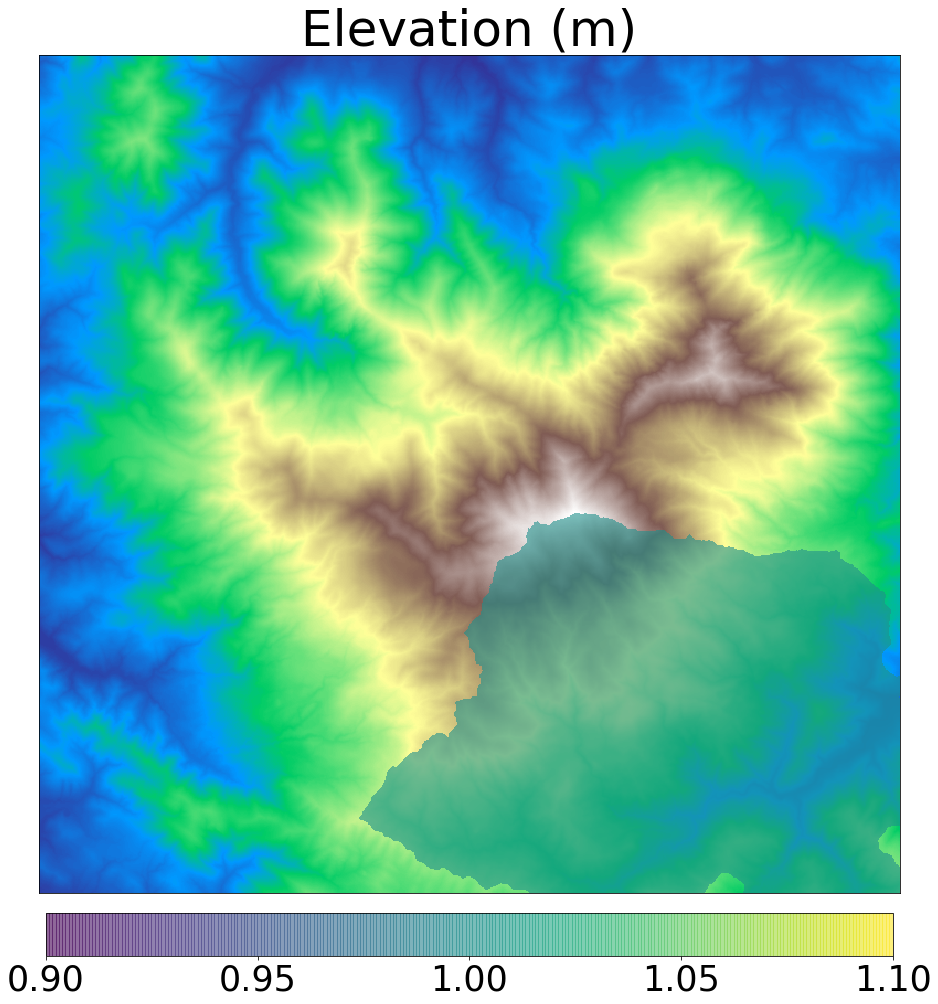

In [73]:
masked = np.ma.masked_where(record==0, record)

plt.figure(figsize=(15,15))
plt.imshow(dem, cmap='terrain')
plt.imshow(masked, alpha=0.6)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',shrink=0.8,pad=0.02)
cb.ax.tick_params(labelsize=35)
plt.title('Elevation (m)',fontsize=50)
plt.tight_layout()
plt.show()